In [1]:
import os

os.environ['HDF5_DISABLE_VERSION_CHECK'] = "1"

import datetime as dt 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from eofs.xarray import Eof
from esem import rf_model
from glob import glob

from matplotlib import colors


import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from utils_rf import *

2024-11-26 21:35:30.263076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732682130.282512   52358 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732682130.288266   52358 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 21:35:30.347514: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# path to save the net-cdf file
path_output ='outputs_ssp245_prediction_ESEm.nc'


### Initial EDA to look at variables 

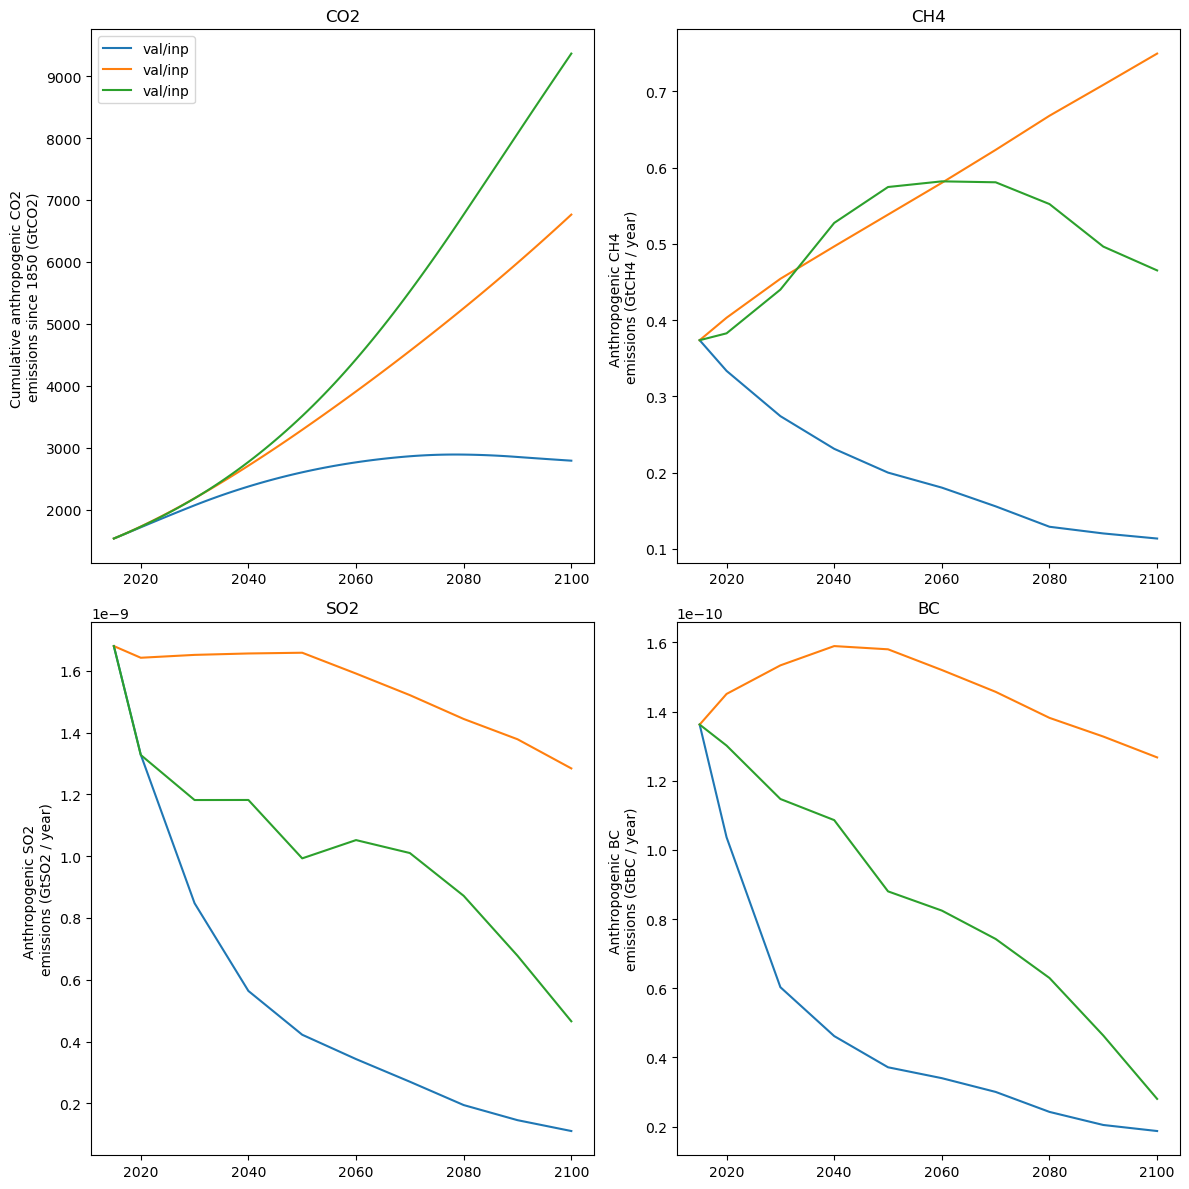

In [3]:
inputs = ["./train_val/inputs_ssp126.nc", "./train_val/inputs_ssp370.nc","./train_val/inputs_ssp585.nc"]
SECONDS_IN_YEAR = 60*60*24*365 

fig, axes = plt.subplots(2, 2, figsize=(12,12))

for input in inputs:
    label=input.split('_')[1][:-3]
    X = xr.open_dataset(input)
    x = range(2015, 2101)

    weights = np.cos(np.deg2rad(X.latitude))
    
    axes[0, 0].plot(x, X['CO2'].data, label=label)
    axes[0, 0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")
    axes[0, 1].plot(x, X['CH4'].data, label=label)
    axes[0, 1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")
    # FIXME: Not sure where this factor of 1000 comes from...! Maybe the CEDS data is really g/m-2/s?
    axes[1, 0].plot(x, X['SO2'].weighted(weights).sum(['latitude', 'longitude']).data*SECONDS_IN_YEAR*1e-9, label=label)
    axes[1, 0].set_ylabel("Anthropogenic SO2 \nemissions (GtSO2 / year)")
    axes[1, 1].plot(x, X['BC'].weighted(weights).sum(['latitude', 'longitude']).data*SECONDS_IN_YEAR*1e-9, label=label)
    axes[1, 1].set_ylabel("Anthropogenic BC \nemissions (GtBC / year)")

axes[0, 0].set_title('CO2')
axes[0, 1].set_title('CH4')
axes[1, 0].set_title('SO2')
axes[1, 1].set_title('BC')
axes[0, 0].legend()
plt.tight_layout()

test_data_path= "./test"+'inputs_ssp245.nc'

### Random Forest Regressor Model Building 

In [4]:
train_files = [ "historical", "ssp585", "ssp126", "ssp370", ]
# Create training and testing arrays
X, solvers = create_predictor_data(train_files)
Y = create_predictdand_data(train_files)



In [5]:
#parameters dictionary
param_dict_tas = {
    'n_estimators': 250,
    'min_samples_split': 5,
    'min_samples_leaf': 7,
    'max_depth': 5
}

param_dict_pr = {
    'n_estimators': 150,
    'min_samples_split': 15,
    'min_samples_leaf': 8,
    'max_depth': 40
}

param_dict_pr90 = {
    'n_estimators': 250,
    'min_samples_split': 15,
    'min_samples_leaf': 12,
    'max_depth': 25
}

param_dict_dtr = {
    'n_estimators': 300,
    'min_samples_split': 10,
    'min_samples_leaf': 12,
    'max_depth': 20
}

In [6]:
rf_tas = rf_model(X, Y['tas'], random_state=0, bootstrap=True, max_features='sqrt', **param_dict_tas)
rf_pr = rf_model(X, Y['pr'], random_state=0, bootstrap=True, max_features='sqrt', **param_dict_pr)
rf_pr90 = rf_model(X, Y['pr90'], random_state=0, bootstrap=True, max_features='sqrt',**param_dict_pr90)
rf_dtr = rf_model(X, Y["diurnal_temperature_range"], random_state=0, bootstrap=True, max_features='sqrt',**param_dict_dtr)

rf_tas.train()
rf_pr.train()
rf_pr90.train()
rf_dtr.train()

2024-11-26 21:35:36.893152: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [7]:
## Test on SSP245 pathway 

X_test = get_test_data('ssp245', solvers)
Y_test = create_predictdand_data_test(['ssp245'])

tas_truth = Y_test["tas"]
pr_truth = Y_test["pr"]
pr90_truth = Y_test["pr90"]
dtr_truth = Y_test["diurnal_temperature_range"]


In [8]:
m_out_tas, _ = rf_tas.predict(X_test)
m_out_pr, _ = rf_pr.predict(X_test)
m_out_pr90, _ = rf_pr90.predict(X_test)
m_out_dtr, _ = rf_dtr.predict(X_test)

In [9]:
xr_output = xr.Dataset(dict(tas=m_out_tas, pr=m_out_pr, pr90=m_out_pr90, diurnal_temperature_range=m_out_dtr)).assign_coords(time=m_out_tas.sample + 2014)
#save output to net-cdf file
xr_output.to_netcdf(path_output,'w')

### Testing out predictions with test set

In [10]:
print(f"RMSE: {get_rmse(tas_truth[35:], m_out_tas[35:]).mean()}")
print("\n")

print(f"RMSE: {get_rmse(dtr_truth[35:], m_out_dtr[35:]).mean()}")
print("\n")

print(f"RMSE: {get_rmse(pr_truth[35:], m_out_pr[35:]).mean()}")
print("\n")

print(f"RMSE: {get_rmse(pr90_truth[35:], m_out_pr90[35:]).mean()}")

RMSE: 0.6823172244093356


RMSE: 0.16537489851670092


RMSE: 0.5578336782743653


RMSE: 1.5880423328622344


### Comparing emulated results of RF model to True Results Graphically (Year 2050)

#### True vs Emulated Surface Air Temperature 

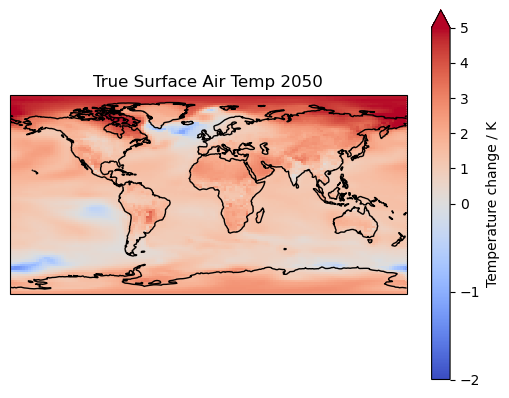

In [11]:
divnorm=colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)

ax = plt.axes(projection=ccrs.PlateCarree())
tas_truth.sel(time=2050).plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
ax.set_title("True Surface Air Temp 2050")
ax.coastlines()
# plt.show()

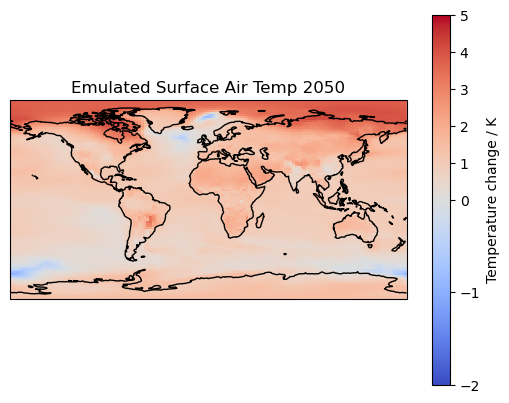

In [12]:
ax = plt.axes(projection=ccrs.PlateCarree())
m_out_tas.sel(sample=35).plot(cmap="coolwarm", norm=divnorm,
                         cbar_kwargs={"label":"Temperature change / K"})
ax.set_title("Emulated Surface Air Temp 2050")
ax.coastlines()
# plt.show()

#### True vs Emulated Diurnal Temperature Range

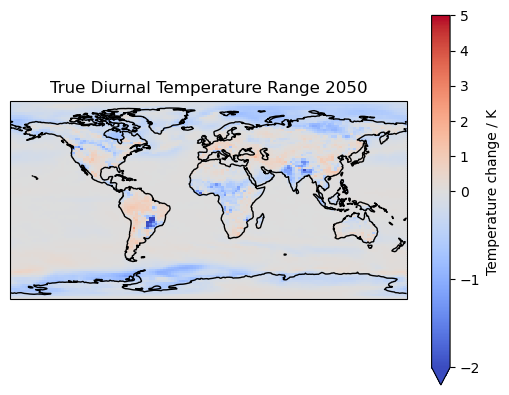

In [13]:
ax = plt.axes(projection=ccrs.PlateCarree())
dtr_truth.sel(time=2050).plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
ax.set_title("True Diurnal Temperature Range 2050")
ax.coastlines()

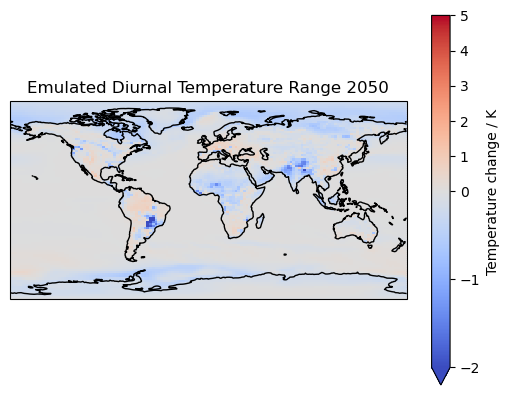

In [14]:
ax = plt.axes(projection=ccrs.PlateCarree())
m_out_dtr.sel(sample=35).plot(cmap="coolwarm", norm=divnorm,
                         cbar_kwargs={"label":"Temperature change / K"})
ax.set_title("Emulated Diurnal Temperature Range 2050")
ax.coastlines()

#### True vs Emulated Percipitation

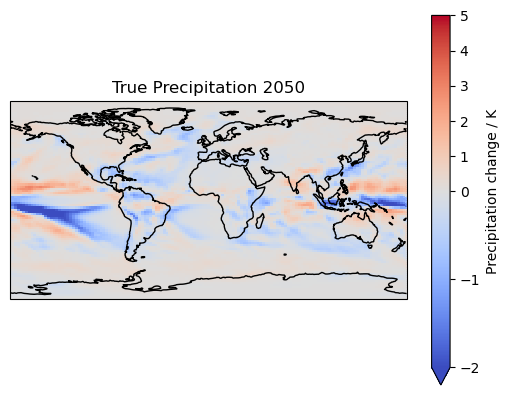

In [15]:
ax = plt.axes(projection=ccrs.PlateCarree())
pr_truth.sel(time=2050).plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Precipitation change / K"})
ax.set_title("True Precipitation 2050")
ax.coastlines()

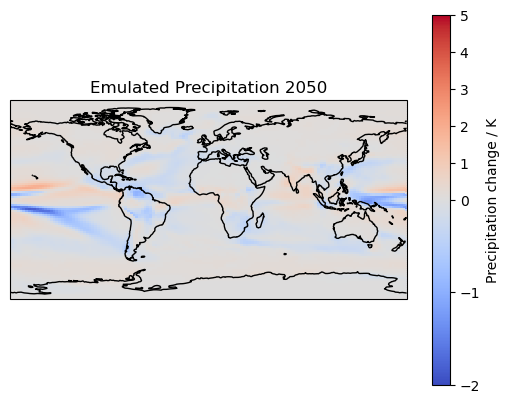

In [16]:
ax = plt.axes(projection=ccrs.PlateCarree())
m_out_pr.sel(sample=35).plot(cmap="coolwarm", norm=divnorm,
                         cbar_kwargs={"label":"Precipitation change / K"})
ax.set_title("Emulated Precipitation 2050")
ax.coastlines()

#### True vs Emulated 90th Percentile Percipitation

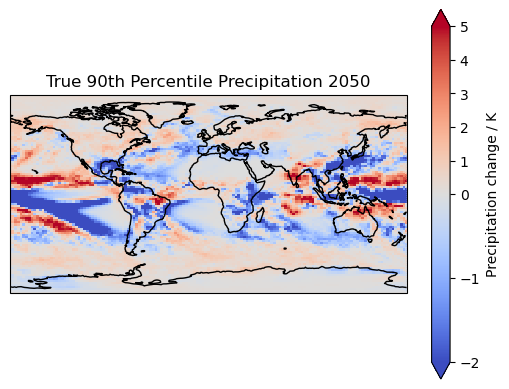

In [17]:

ax = plt.axes(projection=ccrs.PlateCarree())
pr90_truth.sel(time=2050).plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Precipitation change / K"})
ax.set_title("True 90th Percentile Precipitation 2050")
ax.coastlines()

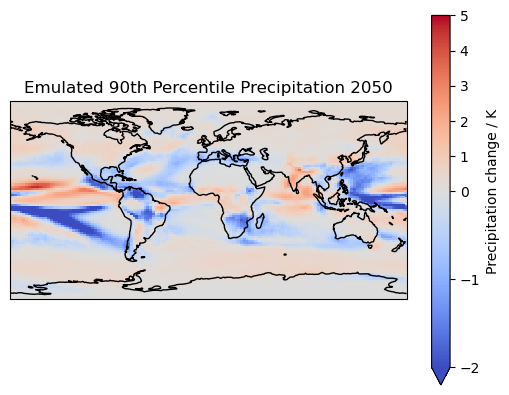

In [18]:
ax = plt.axes(projection=ccrs.PlateCarree())
m_out_pr90.sel(sample=35).plot(cmap="coolwarm", norm=divnorm,
                         cbar_kwargs={"label":"Precipitation change / K"})
ax.set_title("Emulated 90th Percentile Precipitation 2050")
ax.coastlines()

### Running models again with more optimized hyperparameter inputs

In [19]:
X, solvers = create_predictor_data(train_files)
Y = create_predictdand_data(train_files)

In [20]:
# only changed tas and pr parameters as others got worse 
param_dict_tas_opt = {
    'n_estimators': 250,
    'min_samples_split': 15,
    'min_samples_leaf': 10,
    'max_depth': 10
}

param_dict_pr_opt = {
    'n_estimators': 250,
    'min_samples_split': 20,
    'min_samples_leaf': 10,
    'max_depth': 45
}

param_dict_pr90_opt = {
    'n_estimators': 250,
    'min_samples_split': 15,
    'min_samples_leaf': 12,
    'max_depth': 25
}

param_dict_dtr_opt = {
    'n_estimators': 300,
    'min_samples_split': 10,
    'min_samples_leaf': 12,
    'max_depth': 20
}

In [21]:
# Used log2 instead of sqrt for max_features 

rf_tas = rf_model(X, Y['tas'], random_state=0, bootstrap=True, max_features='log2', **param_dict_tas_opt)
rf_pr = rf_model(X, Y['pr'], random_state=0, bootstrap=True, max_features='log2', **param_dict_pr_opt)
rf_pr90 = rf_model(X, Y['pr90'], random_state=0, bootstrap=True, max_features='log2',**param_dict_pr90_opt)
rf_dtr = rf_model(X, Y["diurnal_temperature_range"], random_state=0, bootstrap=True, max_features='log2',**param_dict_dtr_opt)

rf_tas.train()
rf_pr.train()
rf_pr90.train()
rf_dtr.train()

In [22]:
## Test on SSP245

X_test = get_test_data('ssp245', solvers)
Y_test = create_predictdand_data_test(['ssp245'])

tas_truth = Y_test["tas"]
pr_truth = Y_test["pr"]
pr90_truth = Y_test["pr90"]
dtr_truth = Y_test["diurnal_temperature_range"]


In [23]:
# predictions for each variable 
m_out_tas, _ = rf_tas.predict(X_test)
m_out_pr, _ = rf_pr.predict(X_test)
m_out_pr90, _ = rf_pr90.predict(X_test)
m_out_dtr, _ = rf_dtr.predict(X_test)

In [24]:
path_output = "outputs_ssp245_prediction_hyper_change.nc"
xr_output = xr.Dataset(dict(tas=m_out_tas, pr=m_out_pr, pr90=m_out_pr90, diurnal_temperature_range=m_out_dtr)).assign_coords(time=m_out_tas.sample + 2014)
#save output to net-cdf file 
xr_output.to_netcdf(path_output,'w')

### Testing out predictions with test set

In [25]:
print(f"RMSE: {get_rmse(tas_truth[35:], m_out_tas[35:]).mean()}")
print("\n")

print(f"RMSE: {get_rmse(dtr_truth[35:], m_out_dtr[35:]).mean()}")
print("\n")

print(f"RMSE: {get_rmse(pr_truth[35:], m_out_pr[35:]).mean()}")
print("\n")

print(f"RMSE: {get_rmse(pr90_truth[35:], m_out_pr90[35:]).mean()}")

RMSE: 0.6602302805441683


RMSE: 0.16537489851670092


RMSE: 0.5494657322063173


RMSE: 1.5880423328622344


### Comparing emulated results of New RF model to True Results Graphically (Year 2050)

#### True vs Emulated Surface Air Temperature 

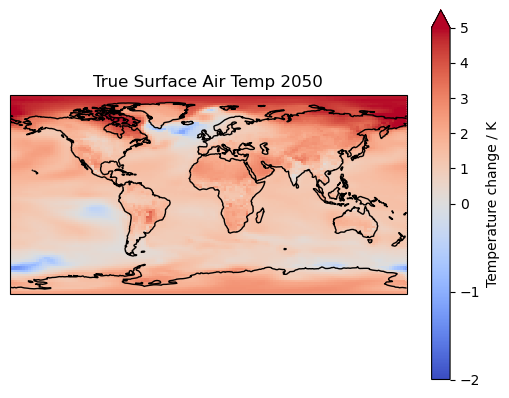

In [26]:
divnorm=colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)

ax = plt.axes(projection=ccrs.PlateCarree())
tas_truth.sel(time=2050).plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
ax.set_title("True Surface Air Temp 2050")
ax.coastlines()
# plt.show()

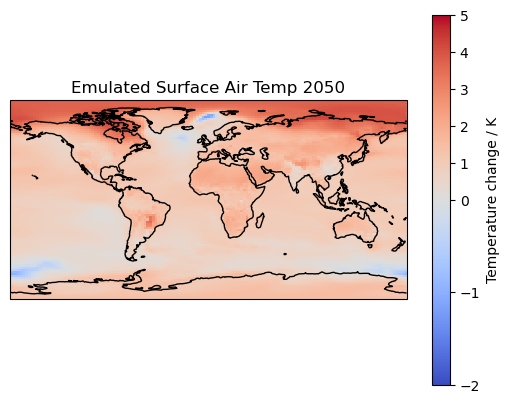

In [27]:
ax = plt.axes(projection=ccrs.PlateCarree())
m_out_tas.sel(sample=35).plot(cmap="coolwarm", norm=divnorm,
                         cbar_kwargs={"label":"Temperature change / K"})
ax.set_title("Emulated Surface Air Temp 2050")
ax.coastlines()
# plt.show()

#### True vs Emulated Diurnal Temperature Range

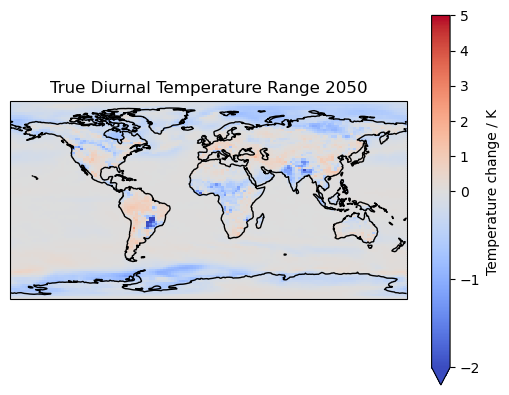

In [28]:
ax = plt.axes(projection=ccrs.PlateCarree())
dtr_truth.sel(time=2050).plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
ax.set_title("True Diurnal Temperature Range 2050")
ax.coastlines()

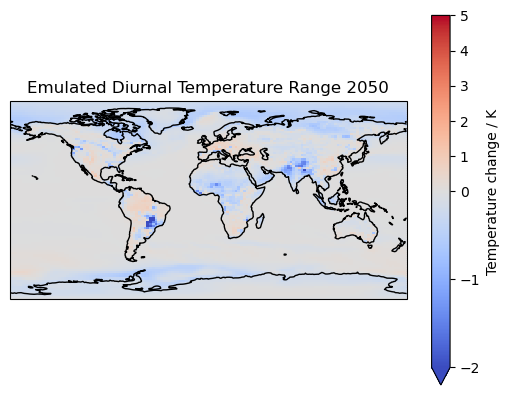

In [29]:
ax = plt.axes(projection=ccrs.PlateCarree())
m_out_dtr.sel(sample=35).plot(cmap="coolwarm", norm=divnorm,
                         cbar_kwargs={"label":"Temperature change / K"})
ax.set_title("Emulated Diurnal Temperature Range 2050")
ax.coastlines()

#### True vs Emulated Precipitation 

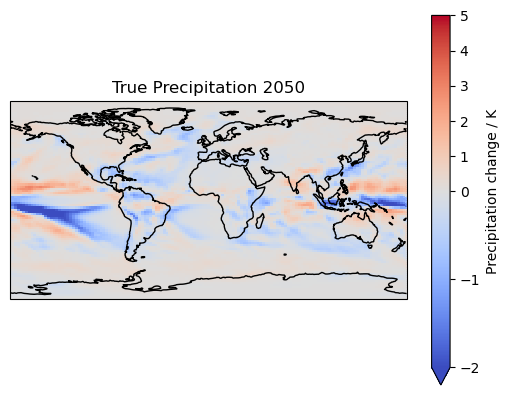

In [30]:
ax = plt.axes(projection=ccrs.PlateCarree())
pr_truth.sel(time=2050).plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Precipitation change / K"})
ax.set_title("True Precipitation 2050")
ax.coastlines()

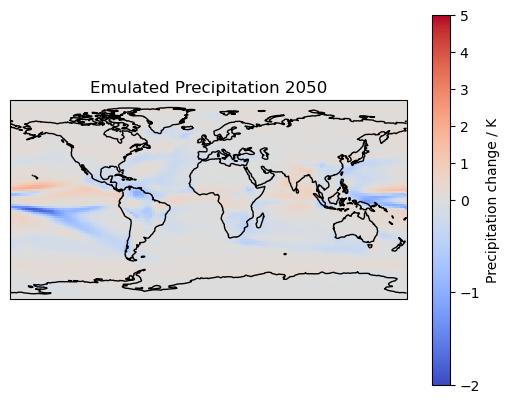

In [31]:
ax = plt.axes(projection=ccrs.PlateCarree())
m_out_pr.sel(sample=35).plot(cmap="coolwarm", norm=divnorm,
                         cbar_kwargs={"label":"Precipitation change / K"})
ax.set_title("Emulated Precipitation 2050")
ax.coastlines()

#### True vs Emulated 90th Percentile Precipitation 

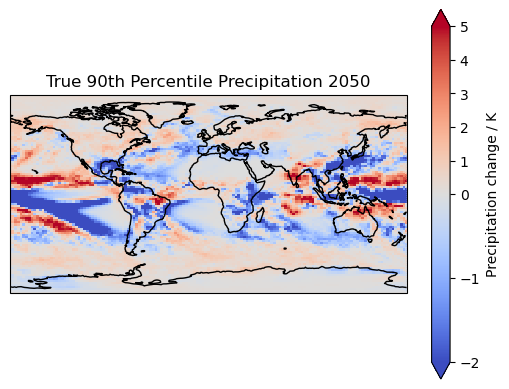

In [32]:
ax = plt.axes(projection=ccrs.PlateCarree())
pr90_truth.sel(time=2050).plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Precipitation change / K"})
ax.set_title("True 90th Percentile Precipitation 2050")
ax.coastlines()

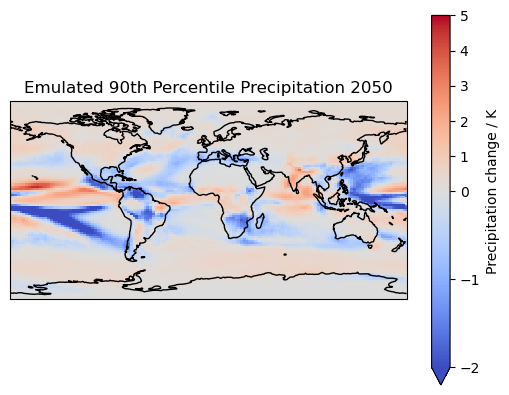

In [33]:
ax = plt.axes(projection=ccrs.PlateCarree())
m_out_pr90.sel(sample=35).plot(cmap="coolwarm", norm=divnorm,
                         cbar_kwargs={"label":"Precipitation change / K"})
ax.set_title("Emulated 90th Percentile Precipitation 2050")
ax.coastlines()